## Load the engineered data

In [1]:
import pandas as pd
data_path = "../data/processed/engineered-customer-data.csv"
data = pd.read_csv(data_path)
data.head()

,ID,Year_Birth,Income,Kidhome,Teenhome,Dt_Customer,Recency,MntWines,MntFruits,MntMeatProducts,...,Education_Master,Education_PhD,Marital_Status_Absurd,Marital_Status_Alone,Marital_Status_Divorced,Marital_Status_Married,Marital_Status_Single,Marital_Status_Together,Marital_Status_Widow,Marital_Status_YOLO
0,5524,1957,58138.0,0,0,04/09/2012,58,635,88,546,...,False,False,False,False,False,False,True,False,False,False
1,2174,1954,46344.0,1,1,08/03/2014,38,11,1,6,...,False,False,False,False,False,False,True,False,False,False
2,4141,1965,71613.0,0,0,21/08/2013,26,426,49,127,...,False,False,False,False,False,False,False,True,False,False
3,6182,1984,26646.0,1,0,10/02/2014,26,11,4,20,...,False,False,False,False,False,False,False,True,False,False
4,5324,1981,58293.0,1,0,19/01/2014,94,173,43,118,...,False,True,False,False,False,True,False,False,False,False


## Customer Segmentation Using RFM Analysis

**Purpose:**

RFM (Recency, Frequency, Monetary) analysis is widely used to identify customer segments based on engagement and spending behavior. This segmentation provides insight into high-value customers and engagement levels

**Define RFM metrics:**
    
        - Recency: Days since the last purchase.
        - Frequency: Total number of purchases.
        - Monetary: Total amount spent by the customer.

**Segment Customers Based on RFM Scores:**
    
        - Divide customers into groups based on RFM scores (e.g., "High Value," "Moderate Value," "Low Value").
        - Summarize insights and highlight segments that can be targeted for CX improvements.

In [9]:
# Calculate RFM metrics
data['R'] = data['Recency']
data['F'] = data[['NumWebPurchases', 'NumCatalogPurchases', 'NumStorePurchases']].sum(axis=1)
data['M'] = data['Total_Spend']

# Define RFM scoring
data['R_score'] = pd.qcut(data['R'], 4, labels=[4, 3, 2, 1])
data['F_score'] = pd.qcut(data['F'], 4, labels=[1, 2, 3, 4])
data['M_score'] = pd.qcut(data['M'], 4, labels=[1, 2, 3, 4])

# Combine scores
data['RFM_Score'] = data['R_score'].astype(int) + data['F_score'].astype(int) + data['M_score'].astype(int)

# Segment based on RFM Score
data['Segment'] = pd.cut(data['RFM_Score'], bins=[0, 4, 8, 12], labels=['Low Value', 'Moderate Value', 'High Value'])


## Prepare data for clustering

In [10]:
# Select features for clustering
features = data[['Age', 'Total_Spend', 'Total_Children']]

## Develop clustering model

### Elbow method to find optimal K

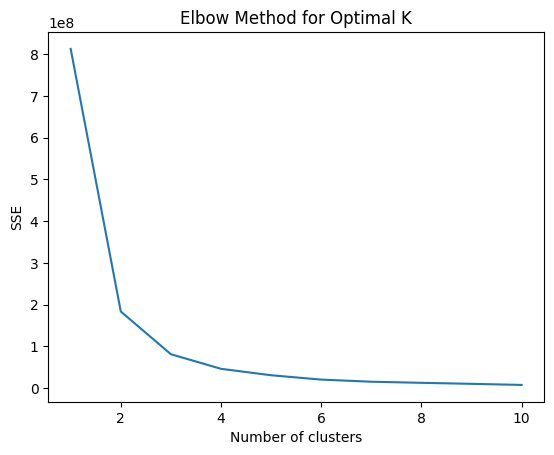

In [11]:
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
from sklearn.metrics import silhouette_score

# Determine the optimal number of clusters
sse = []
for k in range(1, 11):
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(features)
    sse.append(kmeans.inertia_)

# Plot the elbow curve
plt.plot(range(1, 11), sse)
plt.xlabel('Number of clusters')
plt.ylabel('SSE')
plt.title('Elbow Method for Optimal K')
plt.show()


## Fit the final model and evaluate clustering

In [6]:
# Fit the final model
optimal_k = 2  # Silhouette score was high when k is 2, therefore chosen 2 here
kmeans = KMeans(n_clusters=optimal_k, random_state=42)
kmeans.fit(features)
clusters = kmeans.predict(features)


# Add cluster labels to the data
data['cluster'] = clusters

# Evaluate clustering
silhouette_avg = silhouette_score(features, clusters)
print(f'Silhouette Score: {silhouette_avg}')


Silhouette Score: 0.6961524417425303


## Visualise clusters

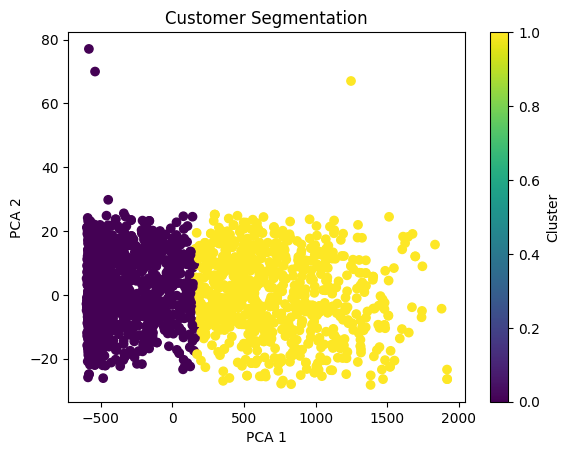

In [7]:
from sklearn.decomposition import PCA

# Reduce dimensions to 2D for visualization
pca = PCA(n_components=2)
reduced_data = pca.fit_transform(features)

# Plot the clusters
plt.scatter(reduced_data[:, 0], reduced_data[:, 1], c=clusters, cmap='viridis')
plt.xlabel('PCA 1')
plt.ylabel('PCA 2')
plt.title('Customer Segmentation')
plt.colorbar(label='Cluster')
plt.show()

## Save the segmented data

In [8]:
# Save the segmented data
segmented_data_path = "../data/processed/segmented-customer-data.csv"
data.to_csv(segmented_data_path, index=False)
